In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load and clean the data
df = pd.read_csv(r'C:\Users\MuriloFarias\Desktop\NN-RONALD\Fraser_Return_Table.csv')
df = df.drop(columns=[col for col in ['Unnamed: 0'] if col in df.columns])
df = df.dropna().reset_index(drop=True)

# 2. Separate target
target_col = 'Total_Returns'
target_series = df[target_col]
df_features = df.drop(columns=[target_col])

# 3. One-hot encode 'River' and 'System'
df_encoded = pd.get_dummies(df_features, columns=['River', 'System'], prefix=['River', 'System']).astype(int)

# 4. Reattach target
df_encoded[target_col] = target_series.values

# 5. Split into train/test
train_df = df_encoded[df_encoded['ReturnYear'] <= 2020].copy()
test_df = df_encoded[df_encoded['ReturnYear'].isin([2021, 2022, 2023, 2024])].copy()

# 6. Remove any non-numeric leftovers
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df = train_df.drop(columns=[col])
        test_df = test_df.drop(columns=[col])

# 7. Define features and target
features = sorted([col for col in train_df.columns if col != target_col])
X_train = train_df[features]
y_train = train_df[target_col]
X_test = test_df[features]
y_test = test_df[target_col]

# 8. Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 9. Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_poly, y_train)

# 10. Predict and evaluate
y_pred = model.predict(X_test_poly)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# 11. Organize results
test_df = test_df.copy()
test_df['Prediction'] = y_pred
test_df['Actual'] = y_test.values
test_df['Error'] = abs(test_df['Prediction'] - test_df['Actual'])
test_df['Pct'] = round((test_df['Prediction'] / test_df['Actual']) * 100, 2)
test_df_sorted = test_df.sort_values(by='ReturnYear')

# 12. Print results
print("\nRandom Forest Regression (Bristol Bay | Train ≤ 2020 | Test: 2021–2024)")
print("-" * 70)

for _, row in test_df_sorted.iterrows():
    year = int(row['ReturnYear'])
    river = [col for col in test_df_sorted.columns if col.startswith("River_") and row[col] == 1]
    system = [col for col in test_df_sorted.columns if col.startswith("System_") and row[col] == 1]
    river_name = river[0].replace("River_", "") if river else "Unknown"
    system_name = system[0].replace("System_", "") if system else "Unknown"

    print(f"Year: {year} | System: {system_name} | River: {river_name}")
    print(f"Prediction: {row['Prediction']:,.0f}")
    print(f"Actual:    {row['Actual']:,.0f}")
    print(f"Error:     {row['Error']:,.0f}")
    print(f"% of Actual: {row['Pct']}%")
    print("-" * 70)

# Final metrics
print(f"MAE:  {mae:,.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape * 100:.2f}%")

# === 13. Forecast 2025 for each River using average of 2019–2024 ===
print("\nForecast for 2025 based on average features (2019–2024)")
print("-" * 70)

all_river_cols = [col for col in df_encoded.columns if col.startswith("River_")]
rivers = sorted([col.replace("River_", "") for col in all_river_cols])

for river in rivers:
    river_col = f"River_{river}"
    df_river = df_encoded[(df_encoded[river_col] == 1) & (df_encoded['ReturnYear'].between(2019, 2024))].copy()

    if df_river.empty:
        print(f"Skipped {river} (no data from 2019–2024)")
        continue

    avg_row = df_river[features].mean().to_frame().T
    avg_row['ReturnYear'] = 2025
    avg_row[river_col] = 1  # Ensure correct river is set to 1

    # Set system column to most common in historical rows
    system_cols = [col for col in df_encoded.columns if col.startswith("System_")]
    if system_cols:
        most_common_system = df_river[system_cols].mean().idxmax()
        avg_row[system_cols] = 0
        avg_row[most_common_system] = 1
        system_name = most_common_system.replace("System_", "")
    else:
        system_name = "Unknown"

    # Apply preprocessing
    X_scaled = scaler.transform(avg_row[features])
    X_poly = poly.transform(X_scaled)
    prediction = model.predict(X_poly)[0]

    print(f"Year: 2025 | System: {system_name} | River: {river}")
    print(f"Predicted Total Returns: {prediction:,.0f}")
    print("-" * 70)



Random Forest Regression (Bristol Bay | Train ≤ 2020 | Test: 2021–2024)
----------------------------------------------------------------------
Year: 2021 | System: Fraser River | River: Chilko
Prediction: 1,123,239
Actual:    1,139,557
Error:     16,318
% of Actual: 98.57%
----------------------------------------------------------------------
Year: 2021 | System: Fraser River | River: Late Stuart
Prediction: 496,601
Actual:    468,145
Error:     28,456
% of Actual: 106.08%
----------------------------------------------------------------------
Year: 2021 | System: Fraser River | River: Raft
Prediction: 7,467
Actual:    5,502
Error:     1,965
% of Actual: 135.71%
----------------------------------------------------------------------
Year: 2021 | System: Fraser River | River: Quesnel
Prediction: 156,547
Actual:    121,552
Error:     34,995
% of Actual: 128.79%
----------------------------------------------------------------------
Year: 2021 | System: Fraser River | River: Stellako
Predic

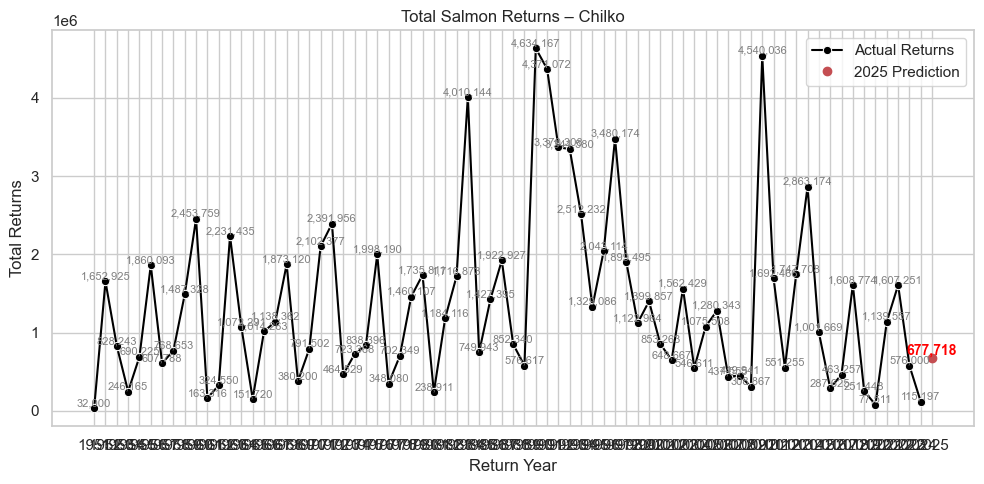

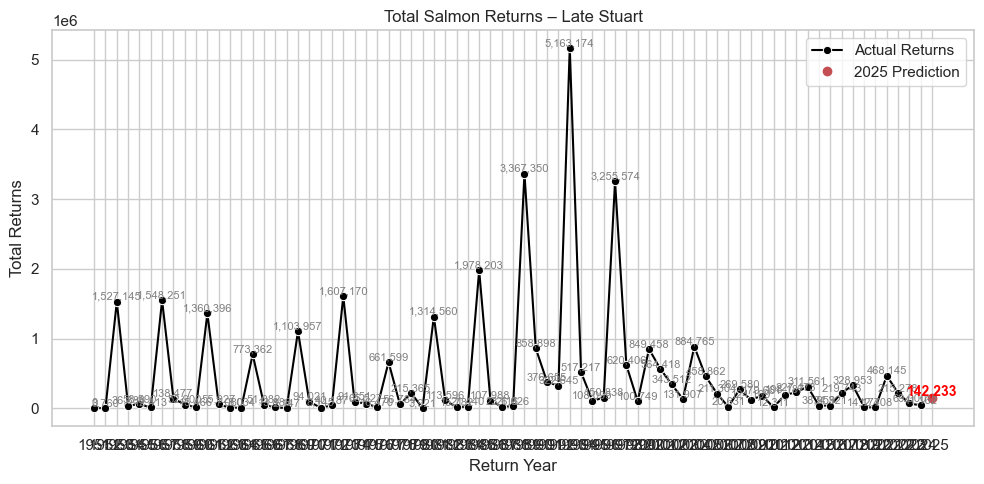

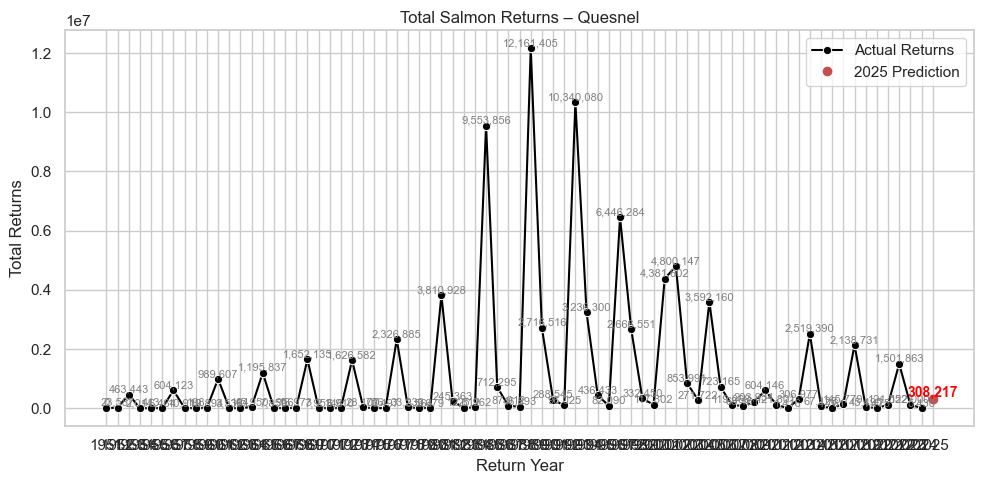

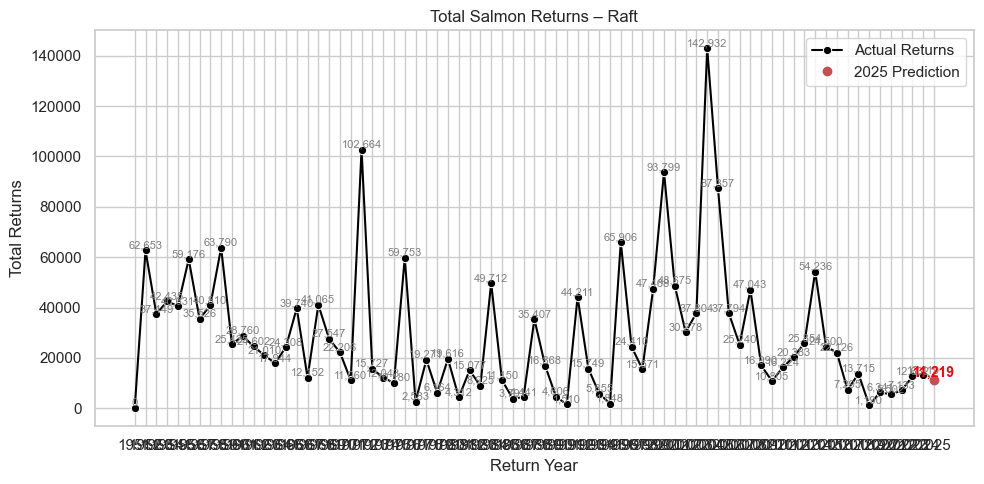

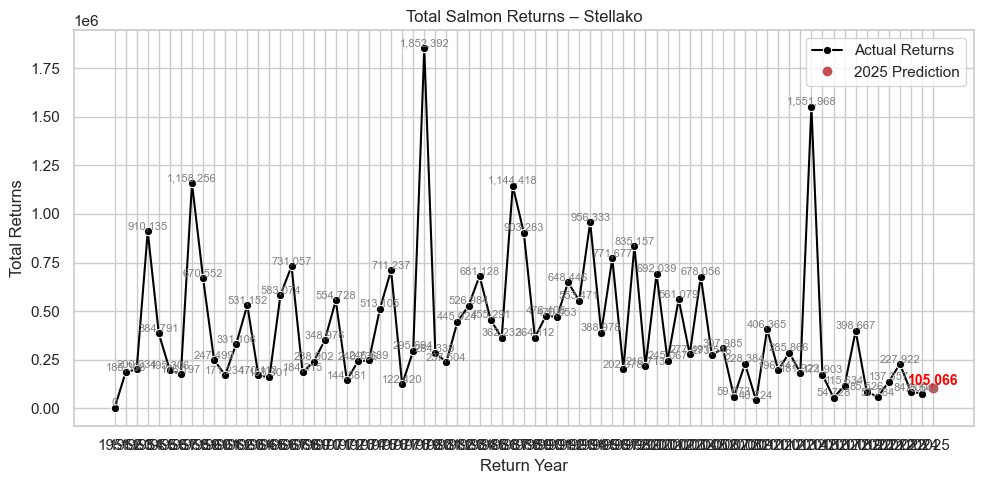

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent style
sns.set(style="whitegrid")

# Step 1: Clean full dataset (no missing target)
df_plot = df.dropna(subset=['Total_Returns']).copy()

# Step 2: Loop by river
rivers = df['River'].unique()

# We assume you have a dict with 2025 predictions per river (from earlier step)
# Format: predictions_2025 = {'River1': 123456, 'River2': 789012, ...}

# You can build this from previous loop if not already:
predictions_2025 = {}
for river in rivers:
    river_col = f"River_{river}"
    df_river = df_encoded[(df_encoded[river_col] == 1) & (df_encoded['ReturnYear'].between(2019, 2024))].copy()
    if df_river.empty:
        continue
    avg_row = df_river[features].mean().to_frame().T
    avg_row['ReturnYear'] = 2025
    avg_row[river_col] = 1
    system_cols = [col for col in df_encoded.columns if col.startswith("System_")]
    if system_cols:
        most_common_system = df_river[system_cols].mean().idxmax()
        avg_row[system_cols] = 0
        avg_row[most_common_system] = 1
    X_scaled = scaler.transform(avg_row[features])
    X_poly = poly.transform(X_scaled)
    prediction = model.predict(X_poly)[0]
    predictions_2025[river] = prediction

# Step 3: Plotting
for river in sorted(rivers):
    df_river = df_plot[df_plot['River'] == river].copy()
    if df_river.empty or river not in predictions_2025:
        continue

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_river, x='ReturnYear', y='Total_Returns', marker='o', color='black', label='Actual Returns')

    # Step 4: Annotate historical points
    for _, row in df_river.iterrows():
        plt.text(row['ReturnYear'], row['Total_Returns'], f"{int(row['Total_Returns']):,}", 
                 color='gray', fontsize=8, ha='center', va='bottom')

    # Step 5: Plot 2025 prediction in RED
    pred_2025 = predictions_2025[river]
    last_year = df_river['ReturnYear'].max()
    plt.plot(2025, pred_2025, 'ro', label='2025 Prediction')
    plt.text(2025, pred_2025, f"{int(pred_2025):,}", color='red', fontsize=10, ha='center', va='bottom', fontweight='bold')

    # Final formatting
    plt.title(f"Total Salmon Returns – {river}")
    plt.xlabel("Return Year")
    plt.ylabel("Total Returns")
    plt.xticks(range(df_river['ReturnYear'].min(), 2026))
    plt.legend()
    plt.tight_layout()
    plt.show()
